# Hull-White Model Implementation

The Hull-White model is an extension of the Vasicek model with a time-dependent drift, making it more flexible for fitting the yield curve. 

## One-Factor Hull-White Model Overview

The Hull-White model assumes the short rate $r(t)$ follows the stochastic differential equation (SDE) under the risk-neutral measure:

$$dr(t) = [\theta(t) - \kappa r(t)]dt + \sigma dW(t)$$

Where:
- $r(t)$: Short rate at time $t$
- $\kappa$: Mean reversion speed
- $\theta(t)$: Time-dependent drift, chosen to fit the initial yield curve
- $\sigma$: Constant volatility
- $dW(t)$: Wiener process increment

Unlike the CIR model, the Hull-White model allows negative rates due to its Gaussian diffusion term, but it's analytically tractable and widely used for interest rate derivatives pricing. The bond price is affine:

$$P(t,T) = A(t,T)e^{-B(t,T)r(t)}$$

Where:

$$B(t,T) = \frac{1 - e^{-\kappa(T-t)}}{\kappa}$$

$$A(t,T) = \exp\left(\int_t^T \theta(s)B(s,T)ds - \frac{\sigma^2}{2}\int_t^T B(s,T)^2ds\right)$$

To fit the initial yield curve, $\theta(t)$ is derived as:

$$\theta(t) = \frac{\partial f(0,t)}{\partial t} + \kappa f(0,t) + \frac{\sigma^2}{2\kappa}(1 - e^{-2\kappa t})$$

Where $f(0,t) = -\frac{\partial \ln P(0,t)}{\partial t}$ is the instantaneous forward rate at time 0 for maturity $t$, typically bootstrapped from the observed yield curve.

For simplicity, we'll parameterize the model with $\kappa$, $\sigma$, and the initial short rate $r_0$, and use the STRIPS data to estimate the forward rates $f(0,t)$.


# Data Preparation
Load and prepare the STRIPS data for February 04, 2025, extracting maturities and yields.

### Data Loading
Extracts maturities and yields for February 04, 2025, scaling yields to percentages.

### Interpolation
Uses linear interpolation to create a dense grid of yields, ensuring smooth estimation of $f(0,t)$.

### Bond Prices
Converts yields to zero-coupon bond prices using:

$$P(0,T) = e^{-y(T)T}$$

### Forward Rates
Estimates $f(0,t)$ numerically as:

$$f(0,t) = -\frac{\partial \ln P(0,t)}{\partial t}$$

using a small time step $dt = 10^{-4}$.

### Spline
Fits a cubic spline to the forward rates for smooth evaluation in $\theta(t)$.

In [45]:
import pandas as pd
import numpy as np

In [46]:
# Data Preparation
df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')
maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
dt = '2025-02-04'
data_on_date = df[df['Date'] == dt]
times = np.array([data_on_date[f'Time_{mat}'].values[0] for mat in maturities])
yields = np.array([data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]) * 100
valid_idx = ~np.isnan(times) & ~np.isnan(yields)
times = times[valid_idx]
yields = yields[valid_idx]

In [47]:
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator

In [48]:
# Forward Rates Calculation

# Ensure times is strictly increasing
times = np.array(times)  # Convert to numpy array if not already
yields = np.array(yields)  # Ensure yields matches times
# Sort by times and remove duplicates
sort_indices = np.argsort(times)
times = times[sort_indices]
yields = yields[sort_indices]
unique_mask = np.ones(len(times), dtype=bool)
unique_mask[1:] = np.diff(times) > 0  # Keep only where diff > 0
times = times[unique_mask]
yields = yields[unique_mask]


time_grid = np.linspace(min(times), max(times), 200)

# Use PchipInterpolator for monotonic, smooth interpolation; assume yields are in percent
interp_func = PchipInterpolator(times, yields, extrapolate=True)
yields_interp = interp_func(time_grid)

dt_small = 1e-4
forward_rates = np.zeros_like(time_grid)
for i, t in enumerate(time_grid):
    if t <= dt_small:
        # Ensure positive forward rate at t=0, yields in % converted to decimal in exponent
        p1 = np.exp(-interp_func(t + dt_small) / 100 * (t + dt_small)) # /100 for decimal yield
        p0 = 1.0
        forward_rates[i] = max(-(np.log(p1) - np.log(p0)) / dt_small, yields[0] / 100) # Floor at first yield
    else:
        p_plus = np.exp(-interp_func(t + dt_small) / 100 * (t + dt_small))
        p_minus = np.exp(-interp_func(t - dt_small) / 100 * (t - dt_small))
        forward_rates[i] = -(np.log(p_plus) - np.log(p_minus)) / (2 * dt_small)

forward_spline = CubicSpline(time_grid, forward_rates, bc_type='natural')
print("Forward rates:", forward_rates[:5])

print("Times after sorting and deduplication:", times[:5])
print("Yields after sorting and deduplication:", yields[:5])
print("Forward rates:", forward_rates[:5])

Forward rates: [0.02860461 0.0426504  0.04990697 0.0464429  0.03556886]
Times after sorting and deduplication: [0.03011636 0.27378508 0.52566735 0.77754962 1.0294319 ]
Yields after sorting and deduplication: [2.52  4.204 3.694 4.243 4.081]
Forward rates: [0.02860461 0.0426504  0.04990697 0.0464429  0.03556886]


# Define the One-Factor Hull-White Model Class

This class implements the Hull-White model, including the computation of $\theta(t)$, bond prices, and yields.

#### Initialization
- Takes $r_0$, $\kappa$, $\sigma$, and the forward rate spline.
- Clamps $\kappa$ and $\sigma$ to avoid division by zero.

#### $B(t,T)$
- Computes the loading factor:
$$B(t,T) = \frac{1 - e^{-\kappa(T-t)}}{\kappa}$$
- Handles $\kappa \to 0$ by approximating $B \approx \tau$.

#### $\theta(t)$
- Calculates the time-dependent drift using the forward rate spline.
- Numerically estimates $\frac{\partial f}{\partial t}$.

#### $A(t,T)$
- Numerically integrates the two terms in the exponent using a simple trapezoidal rule over 100 points:
$$A(t,T) = \exp\left(\int_t^T \theta(s)B(s,T)ds - \frac{\sigma^2}{2}\int_t^T B(s,T)^2ds\right)$$
- Avoids analytical integration, which is complex for arbitrary $\theta(t)$.

#### `zero`
- Computes the bond price:
$$P(t,T) = A(t,T)e^{-B(t,T)r(t)}$$
- Clamps to $1e^{-10}$ to avoid log(0).

#### `yield_curve`
- Calculates the yield as:
$$Y(t,T) = -\frac{\ln(P)}{\tau} \times 100$$

#### `update_params`
- Updates parameters during optimization, maintaining positivity constraints.

In [49]:
from scipy.integrate import quad

In [50]:
#One Factor Hull-White Model
class One_Factor_Model:
    def __init__(self, r0, kappa, sigma, times, forward_rates):
        self.r0 = r0
        self.kappa = max(kappa, 1e-6)
        self.sigma = max(sigma, 1e-6)
        self.forward_spline = CubicSpline(times, forward_rates, bc_type='natural')
    
    def B(self, t, T):
        tau = T - t
        if tau <= 0:
            return 0
        if self.kappa < 1e-6:
            return tau
        return (1 - np.exp(-self.kappa * tau)) / self.kappa
    
    def theta(self, t):
        f_t = self.forward_spline(t)
        df_dt = self.forward_spline.derivative()(t)
        term2 = self.kappa * f_t
        term3 = (self.sigma**2 / (2 * self.kappa)) * (1 - np.exp(-2 * self.kappa * t)) if self.kappa > 1e-6 else 0
        theta_val = df_dt + term2 + term3
        # print(f"t={t}, f_t={f_t}, df_dt={df_dt}, theta={theta_val}")
        return theta_val

    def A(self, t, T):
        tau = T - t
        if tau <= 0:
            return 1.0
        steps = [t + i * tau / 20 for i in range(21)]  # More subintervals
        integral1 = 0
        integral2 = 0
        for i in range(len(steps) - 1):
            int1, err1 = quad(lambda s: self.theta(s) * self.B(s, T), steps[i], steps[i+1], limit=100)
            int2, err2 = quad(lambda s: self.B(s, T)**2, steps[i], steps[i+1], limit=100)
            integral1 += int1
            integral2 += int2
            # print(f"Subinterval [{steps[i]},{steps[i+1]}]: int1={int1}, err1={err1}")
        result = np.exp(integral1 - (self.sigma**2 / 2) * integral2)
        # print(f"A({t},{T}): integral1={integral1}, integral2={integral2}, result={result}")
        return result

    def zero(self, t0, T, r_t0):
        tau = T - t0
        if tau <= 0:
            return 1.0
        A = self.A(t0, T)
        B = self.B(t0, T)
        p = A * np.exp(-B * r_t0)
        # print(f"P({t},{T}): A={A}, B={B}, r={r_t0}, P={p}")
        return max(p, 1e-10)

    def yield_curve(self, tau):
        if tau <= 0:
            return np.nan
        p = self.zero(0, tau, self.r0)
        y = -np.log(p) / tau * 100
        return y

    def update_params(self, x):
        self.r0 = x[0]
        self.kappa = max(x[1], 1e-6)
        self.sigma = max(x[2], 1e-6)

# Test the Model
Initialize with reasonable parameters and compute initial yields

#### Parameters
- $r_0 = 0.04$: Initial short rate set to 4%, matching previous models.
- $\kappa = 0.1$: Moderate mean reversion speed.
- $\sigma = 0.05$: Volatility set to 5%, typical for interest rate models.

#### Yields
Computes yields at the observed maturities, which should be close to the STRIPS yields due to $\theta(t)$ being calibrated to the forward curve.

In [51]:
# Test Model
r0 = forward_rates[0]
kappa, sigma = 0.05, 0.01
m = One_Factor_Model(r0, kappa, sigma,times=time_grid, forward_rates=forward_rates)
model_yields = [m.yield_curve(t) for t in times]

print("Model prices:", [m.zero(0, t, m.r0) for t in times[:5]])
print("Initial model yields (%):", model_yields[:5])
print("Data yields (%):", yields[:5])


print("Theta at t=0.5:", m.theta(0.5))
print("A(0,0.5257):", m.A(0, 0.5256673511293635))


Model prices: [0.9992329995751393, 0.9976512681836848, 0.9930304585148788, 0.9941337814943089, 0.9909643242169859]
Initial model yields (%): [2.547767241322447, 0.8588833345194296, 1.3304882193807785, 0.7566709796020598, 0.881723707688401]
Data yields (%): [2.52  4.204 3.694 4.243 4.081]
Theta at t=0.5: 0.18596308036325876
A(0,0.5257): 1.0078775485108271


In [52]:
from matplotlib import pyplot as plt

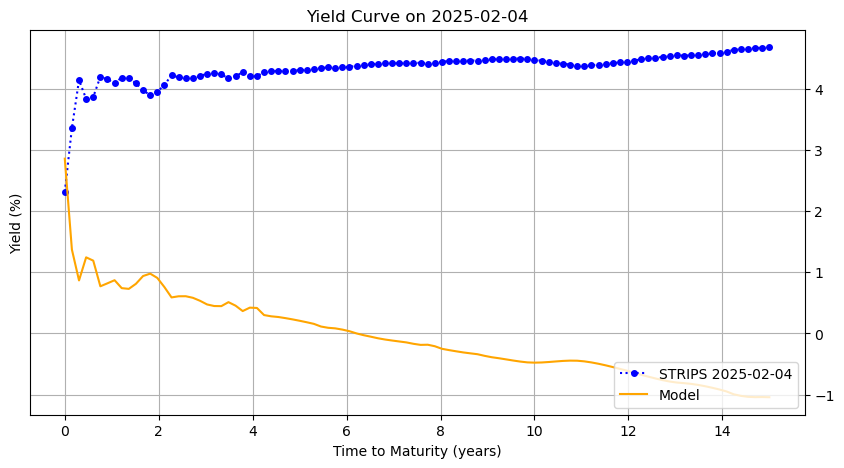

In [53]:
#Plot Initial Fit
def plot_yields(dt, obs_times, obs_yields, model, min_time=1e-4, max_time=15, num_points=100):
    time_grid = np.linspace(min_time, max_time, num_points)
    interp_func = interp1d(obs_times, obs_yields, kind='linear', bounds_error=False, fill_value='extrapolate')
    strips_interp_yields = interp_func(time_grid)
    model_yields = [model.yield_curve(t) for t in time_grid]
    
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    plt.plot(time_grid, strips_interp_yields, label=f'STRIPS {dt}', linestyle='dotted', marker='o', color='blue', markersize=4)
    plt.plot(time_grid, model_yields, label='Model', linestyle='solid', color='orange')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend(loc='lower right')
    plt.title(f'Yield Curve on {dt}')
    plt.grid(True)
    plt.show()

plot_yields(dt, times, yields, m)

In [54]:
from scipy.optimize import least_squares
import warnings

In [55]:
# Optimization
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)
        self.times = np.array(obs_times)
        self.dist = dist
    
    def residuals(self, x):
        m = self.model
        m.update_params(x)
        model_yields = np.array([m.yield_curve(t) for t in self.times])
        if self.dist == 'Q':
            return model_yields - self.data
        elif self.dist == 'WLS':
            weights = 1 / self.times
            return weights * (model_yields - self.data)
        else:
            raise ValueError("dist must be 'Q' or 'WLS'")
    
    def fit(self, x0, solver='trf'):
        bounds = ([1e-6, 1e-6, 1e-6], [np.inf, 0.5, 0.5])
        result = least_squares(self.residuals, x0, method=solver, bounds=bounds, verbose=1)
        if not result.success:
            warnings.warn("Fit did not converge")
        return result

# Test and Fit

x0 = [0.04, 0.05, 0.05]
fitter = Fitter(m, yields, times, 'Q')
fit_result = fitter.fit(x0)
print("Optimized parameters [r0, kappa, sigma]:", fit_result.x)
m.update_params(fit_result.x)

plot_yields(dt, times, yields, m)

KeyboardInterrupt: 

In [ ]:
# Collinearity Check
jac = fit_result.jac
c = np.cov(np.transpose(jac))
val, vec = np.linalg.eig(c)
cn = val[0] / val[-1]
print("Condition number:", cn)